filtered data: https://jmcauley.ucsd.edu/data/googlelocal/kcore/

In [1]:
import gzip
from collections import defaultdict
import datetime
import dateutil
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
import pandas as pd
import math
import heapq
import string
from nltk.corpus import stopwords

In [2]:
path = 'C:/Users/david/Documents/GitHub/CSE-158---CA-Google-Local-Predictions/'

def parseData(fname):
    for l in gzip.open(fname):
        d = eval(l)
        yield d

#filtering out users with <5 interactions
data_CA5 = list(parseData(path+"CA_5.json.gz"))

In [3]:
data_CA5[0]

{'rating': 4.0,
 'reviewerName': 'Mary Gainza',
 'reviewText': 'Gap always has a jean that fits awesomely, i wish their prices were a bit competitive in comparison to their outlets, also the amount of the pieces they have in store sometimes fly so quick that is hard to find an specific size with their best sellers, but in general i really like this store and most of their products.',
 'categories': ['Clothing Store',
  "Women's Clothing Store",
  "Children's Clothing Store"],
 'gPlusPlaceId': '100556368174926958612',
 'unixReviewTime': 1355436757,
 'reviewTime': 'Dec 13, 2012',
 'gPlusUserId': '100000715097692381911'}

In [4]:
places_CA = list(parseData(path+'places_CA.json.gz'))

In [5]:
print(len(data_CA5),len(places_CA))

163408 171271


**EDA**<br />
1) distribution of reviews across time of day (David): **more or less done as of (11/25)**<br />
2) distribution across years/months (David): **more or less done as of (11/25)**<br />
3) categories for businesses (Andrew)<br />
4) length of reviews (Andrew) <br />
5) distribution of words in review (Maricela)<br />
6) top 10 words (Maricela)

# **EDA #0: Ratings Distribution**

In [6]:
pd.Series([d["rating"] for d in data_CA5]).describe()

count    163408.000000
mean          4.049765
std           0.881164
min           0.000000
25%           4.000000
50%           4.000000
75%           5.000000
max           5.000000
dtype: float64

4.0    68943
5.0    56194
3.0    30184
2.0     6401
1.0     1668
0.0       18
dtype: int64

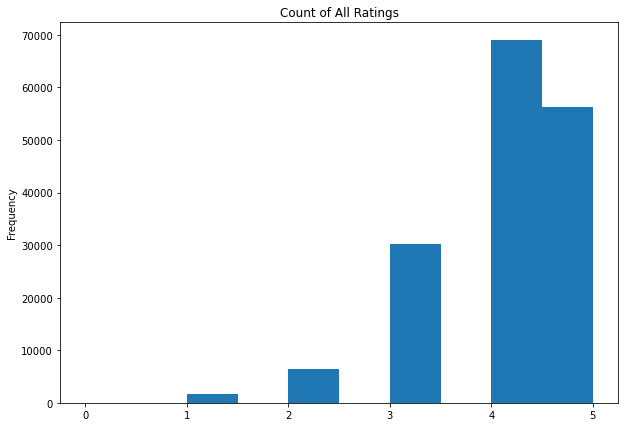

In [7]:
pd.Series([d["rating"] for d in data_CA5]).plot(
    kind="hist",
    title="Count of All Ratings",
    figsize=(10,7))
pd.Series([d["rating"] for d in data_CA5]).value_counts()

# **EDA #1: Distributions of Ratings by time of day (David)**

In [8]:
count = 0
lst = set()
for d in data_CA5:
    if type(d['unixReviewTime']) != int:
        count +=1
        lst.add(d['unixReviewTime'])
print(count,lst)

# might need to remove missing datetimes for the entire analysis: 
# 13,249 missing datetimes in data_CA5
# 5,280 missing datetimes in data_CA10
ratingsTime_5 = []
for d in data_CA5:
    if d['unixReviewTime'] != None:
        t = datetime.datetime.fromtimestamp(d['unixReviewTime'])
        ratingsTime_5.append((t,d['rating']))
ratingsTime_5.sort()
len(ratingsTime_5)

13249 {None}


150159

In [9]:
ratingsTimesOfDay = []
for t,r in ratingsTime_5:
    ratingsTimesOfDay.append((t.hour,t.minute,r))
ratingsTimesOfDay.sort()

In [10]:
tenMinInts = defaultdict(list)
fifteenMinInts = defaultdict(list)
hourlyInts = defaultdict(list)
hour = 0
for h,m,r in ratingsTimesOfDay:
    if h == hour:
        for minute in [10,20,30,40,50,60]:
            if m in [i for i in range(0+minute-10,minute)]:
                tenMinInts[h,minute-10].append(r)
        for minute in [15,30,45,60]:
            if m in [i for i in range(0+minute-15,minute)]:
                fifteenMinInts[h,minute-15].append(r)
        hourlyInts[h].append(r)
    hour = h
tenMinIntKeys = [h*60+m for h,m in list(tenMinInts.keys())]
fifteenMinIntKeys = [h*60+m for h,m in list(fifteenMinInts.keys())]
hourlyIntKeys = [h for h in list(hourlyInts.keys())]
#print(tenMinIntKeys)
tenMinAvgs = []
fifteenMinAvgs = []
hourlyAvgs = []
for key in tenMinInts:
    tenMinAvgs.append(np.mean(tenMinInts[key]))
for key in fifteenMinInts:
    fifteenMinAvgs.append(np.mean(fifteenMinInts[key]))
for key in hourlyInts:
    hourlyAvgs.append(np.mean(hourlyInts[key]))
print('10 min ints: ',min(tenMinAvgs),max(tenMinAvgs))
print('15 min ints: ',min(fifteenMinAvgs),max(fifteenMinAvgs))
print('hourly ints: ',min(hourlyAvgs),max(hourlyAvgs))
#print(tenMinAvgs)

10 min ints:  3.7801047120418847 4.328571428571428
15 min ints:  3.8151260504201683 4.209756097560976
hourly ints:  3.911318553092182 4.167906662157592


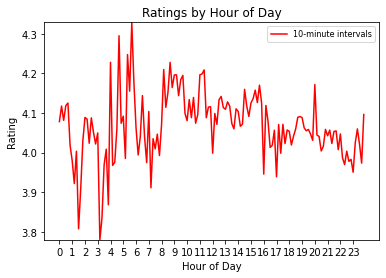

In [11]:
plt.plot(tenMinIntKeys,tenMinAvgs,label='10-minute intervals',color='red')
plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(tenMinAvgs),max(tenMinAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

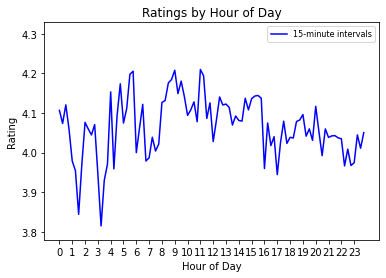

In [12]:
plt.plot(fifteenMinIntKeys,fifteenMinAvgs,label='15-minute intervals',color='blue')
plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(tenMinAvgs),max(tenMinAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

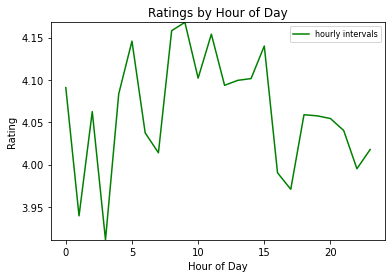

In [13]:
plt.plot(hourlyIntKeys,hourlyAvgs,label='hourly intervals',color='green')
#plt.xticks(tenMinIntKeys[::6], [int(x/60) for x in tenMinIntKeys[::6]])
plt.ylim(min(hourlyAvgs),max(hourlyAvgs))
plt.ylabel("Rating")
plt.xlabel("Hour of Day")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings by Hour of Day")
plt.show()

# **EDA #2: Distribution of Ratings across years/months (David)**

In [14]:
# might need to remove missing datetimes for the entire analysis: 
# 13,249 missing datetimes in data_CA5
# 5,280 missing datetimes in data_CA10

# using the same ratingsTime_5 list as Distribution of Ratings for time of day EDA

In [15]:
wSize = 4000
x = [r[0] for r in ratingsTime_5] # as raw times
y = [r[1] for r in ratingsTime_5] # ratings
xu = [time.mktime(d.timetuple()) for d in x] # as unix times

In [16]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [17]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [18]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

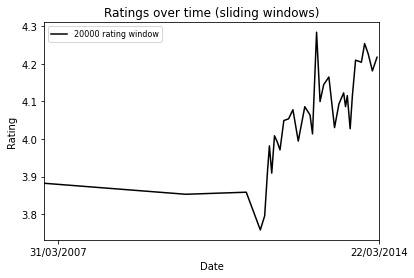

In [19]:
#remove outlier?
plt.plot(X[::4000],Y[::4000], label="20000 rating window", color='k')
plt.xticks([X[100], X[-350]], [x[wSize+100].strftime("%d/%m/%Y"), x[-350].strftime("%d/%m/%Y")])
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best",fontsize=8)
plt.title("Ratings over time (sliding windows)")
plt.show()

# **EDA #3: Categories of Businesses (Andrew)**<br />
can you look into building a popularity feature for categories?

In [20]:
cats = defaultdict(list)
for d in data_CA5:
    if d['categories']:
        for c in d['categories']:
            cats[c].append(d['rating'])
    else:
        cats["None"].append(d['rating'])

In [21]:
cat = [[c, len(cats[c]), np.mean(cats[c])] for c in cats]

<AxesSubplot:title={'center':'Histogram of Average Ratings per Category'}, ylabel='Frequency'>

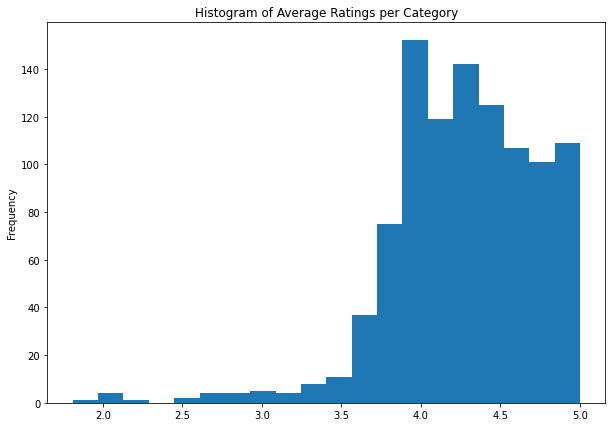

In [22]:
dfCats = pd.DataFrame(cat)
dfCats.sort_values(1, ascending=False).set_index(0)[2].plot(
    kind="hist", 
    title="Histogram of Average Ratings per Category",
    figsize=(10, 7),bins=20)

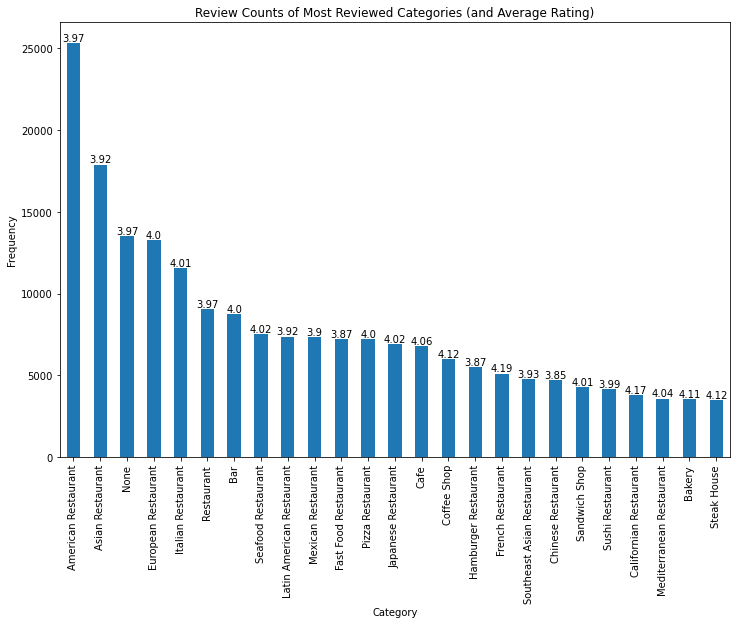

In [23]:
dfCatsCount = dfCats.sort_values(1, ascending=False)[:25].set_index(0)
plt.figure(figsize=(12, 8))
ax = dfCatsCount[1].plot(kind="bar")
ax.set_title("Review Counts of Most Reviewed Categories (and Average Rating)")
ax.set_xlabel("Category")
ax.set_ylabel("Frequency")

rects = ax.patches

# Make some labels.
labels = dfCatsCount[2].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

<Figure size 432x288 with 0 Axes>

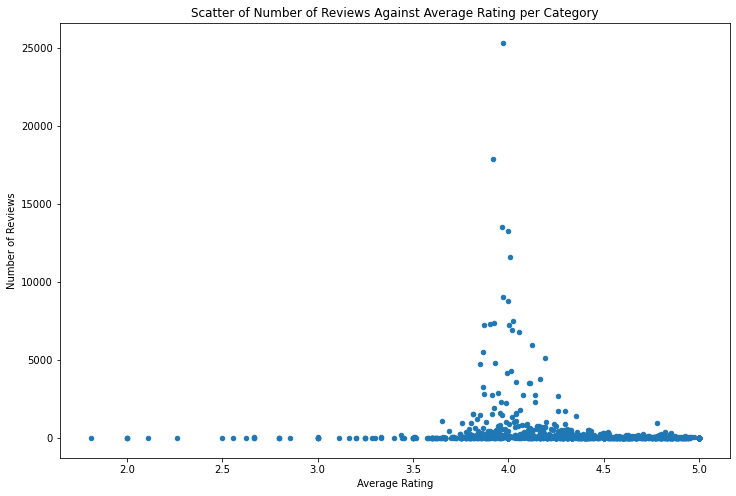

In [24]:
#All the top reviews were around 4, so this checks out
plt.figure()
ax = dfCats.set_index(0).plot(kind="scatter", x=2, y=1, figsize=(12, 8))
ax.set_title("Scatter of Number of Reviews Against Average Rating per Category")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Number of Reviews")

plt.show()

# **EDA #4: Length of Reviews (Andrew)**

In [25]:
dfWords = pd.DataFrame([[len(d["reviewText"].split()), d["rating"]] for d in data_CA5 if d["reviewText"]], columns = ['words', 'rating'])

In [26]:
cats2 = defaultdict(list)
for d in data_CA5:
    if d['categories']:
        i = d['categories']
    else:
        i = ["None"]
    if d['reviewText']:
        w = len(d['reviewText'].split())
    else:
        w = 0
    for c in i:
        if c in cats2:
            cats2[c][0].append(d['rating'])
            cats2[c][1].append(w)
        else:
            cats2[c].append([d['rating']])
            cats2[c].append([w])

In [27]:
c2 = [(c, len(cats2[c][0]), np.mean(cats2[c][0]), np.mean(cats2[c][1])) for c in cats]

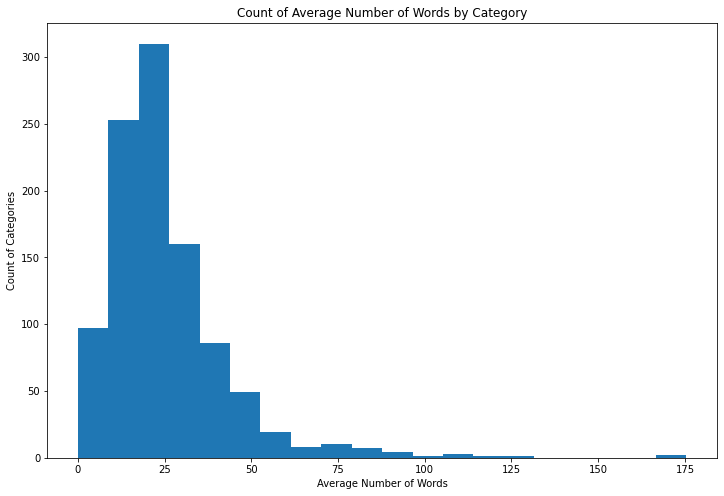

In [28]:
#All the top reviews were around 4, so this checks out
plt.figure()
ax = pd.DataFrame(c2).sort_values(3, ascending=False).set_index(0)[3].plot(kind="hist", figsize=(12, 8),bins=20)
ax.set_title("Count of Average Number of Words by Category")
ax.set_xlabel("Average Number of Words")
ax.set_ylabel("Count of Categories")

plt.show()

<AxesSubplot:title={'center':'Count of Number of Words in All Reviews'}, ylabel='Frequency'>

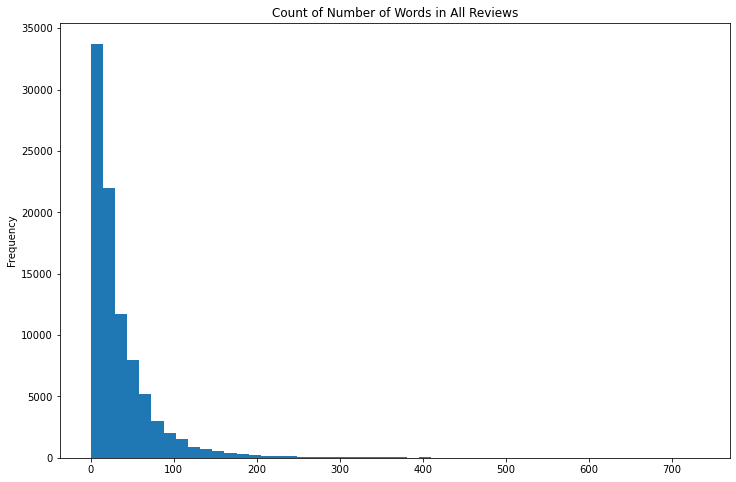

In [29]:
#Count of all words binned
#might not use this
dfWords["words"].plot(kind="hist", bins=50, figsize=(12,8), title="Count of Number of Words in All Reviews")

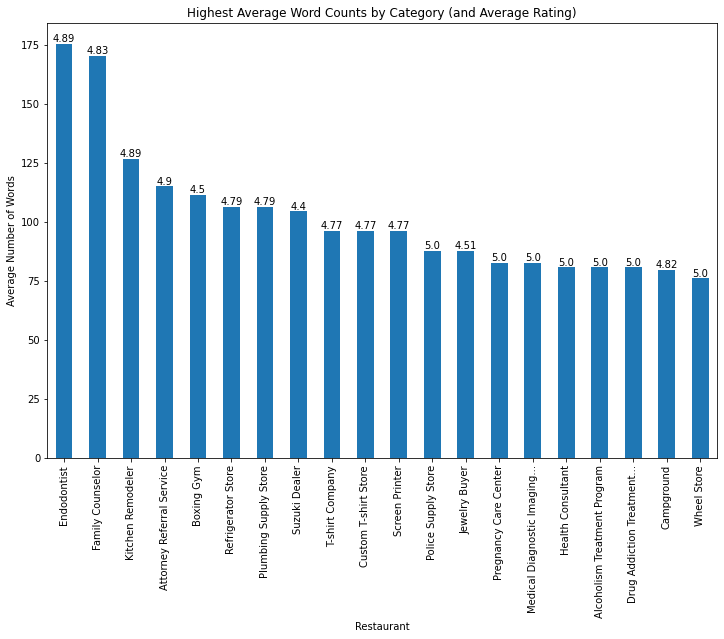

In [30]:
topAvgWords = pd.DataFrame(c2).sort_values(3, ascending=False)[:20].set_index(0)
plt.figure(figsize=(12, 8))
ax = topAvgWords[3].plot(kind="bar")
ax.set_title("Highest Average Word Counts by Category (and Average Rating)")
ax.set_xlabel("Restaurant")
ax.set_ylabel("Average Number of Words")

rects = ax.patches

# Make some labels.
labels = topAvgWords[2].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
    )

plt.show()

<Figure size 432x288 with 0 Axes>

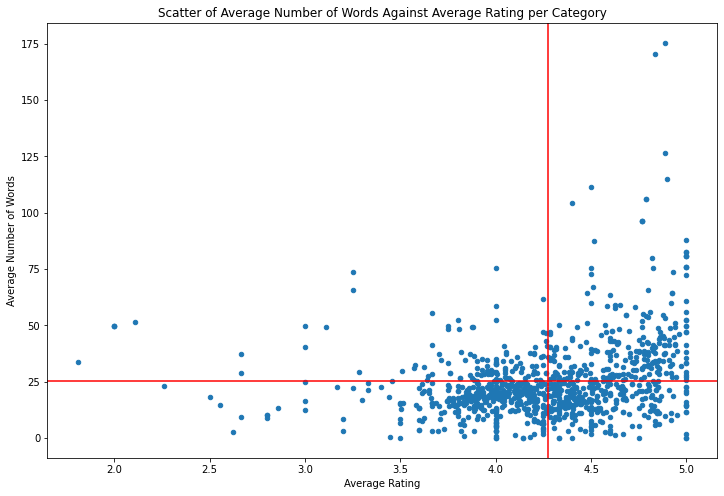

In [31]:
#All the top ratings were around 5, so this checks out
plt.figure()
dfWordsRating = pd.DataFrame(c2)
ax = dfWordsRating.set_index(0).plot(kind="scatter", x=2, y=3, figsize=(12, 8))
ax.set_title("Scatter of Average Number of Words Against Average Rating per Category")
ax.set_xlabel("Average Rating")
ax.set_ylabel("Average Number of Words")

plt.axhline(y=pd.DataFrame(c2).mean()[3], color='r', linestyle='-') 
plt.axvline(x=pd.DataFrame(c2).mean()[2], color='r', linestyle='-') 



plt.show()

# **EDA #5: top words in reviews**

In [32]:
data_CA5[0]

{'rating': 4.0,
 'reviewerName': 'Mary Gainza',
 'reviewText': 'Gap always has a jean that fits awesomely, i wish their prices were a bit competitive in comparison to their outlets, also the amount of the pieces they have in store sometimes fly so quick that is hard to find an specific size with their best sellers, but in general i really like this store and most of their products.',
 'categories': ['Clothing Store',
  "Women's Clothing Store",
  "Children's Clothing Store"],
 'gPlusPlaceId': '100556368174926958612',
 'unixReviewTime': 1355436757,
 'reviewTime': 'Dec 13, 2012',
 'gPlusUserId': '100000715097692381911'}

In [33]:
wordCount = defaultdict(int)
for d in data_CA5:
    if type(d['reviewText']) == str:
        for w in d['reviewText'].split():
            wordCount[w] += 1

In [34]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data_CA5:
    if type(d['reviewText']) == str:
        r = ''.join([c for c in d['reviewText'].lower() if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [35]:
words = [x[1] for x in counts[:1000]]

In [36]:
#removing stop words
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
stop_words = set(stopwords.words('english'))

In [38]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data_CA5:
    if type(d['reviewText']) == str:
        r = ''.join([c for c in d['reviewText'].lower() if not c in punctuation])
        for w in r.split():
            if w not in stop_words:
                wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [39]:
#EDA top words
counts[:10]

[(28827, 'food'),
 (28762, 'good'),
 (27991, 'great'),
 (23042, 'place'),
 (14069, 'service'),
 (11499, 'like'),
 (11397, 'get'),
 (10658, 'best'),
 (10246, 'one'),
 (10117, 'really')]

# Train-Validation-Test Split (70%-20%-10%)

In [40]:
X=[]
y=[]
for rowDict in data_CA5:
    data = []
    for key in rowDict:
        if key == 'rating':
            y.append(rowDict[key])
        else:
            data.append(rowDict[key])
    X.append(data)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=(10/30))
print(len(X_train),len(X_val),len(X_test))

114385 32682 16341


# **Trivial Model (1): Predict the Global Average from Train**

In [41]:
ratingsGlobalAvg = np.mean(y_train)
ratingsGlobalAvg

4.04956069414696

In [42]:
print("Trivial Model MSE: ", str(np.mean(((y_test-ratingsGlobalAvg)**2))))
#print("MAE: ", str(np.mean(abs((y_test-ratingsGlobalAvg)))))

Trivial Model MSE:  0.7644270984933371


# **Simple Baseline Model (2): Weighted Average Using Ratings**

In [43]:
#Calculate Category Averages
cats = defaultdict(list)
for i in range(len(X_train)):
    d = X_train[i]
    if d[2]:
        for c in d[2]:
            cats[c].append(y_train[i])
    else:
        cats["None"].append(y_train[i])
    
ratingsCatAvg = {c: np.mean(cats[c]) for c in cats}
#ratingsCatAvg

In [44]:
preds = [np.mean([ratingsCatAvg[c] if c in ratingsCatAvg else ratingsCatAvg['None'] for c in d[2]])
        if d[2] else ratingsCatAvg['None']
        for d in X_test]

<Figure size 432x288 with 0 Axes>

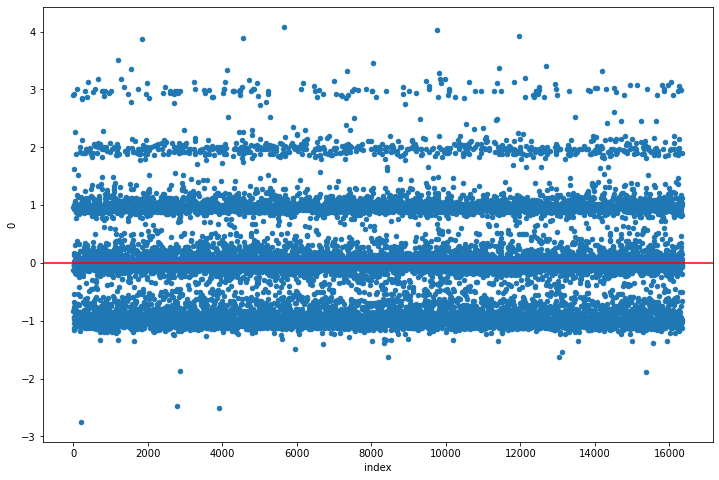

In [45]:
#Calculating error
errors = (pd.Series(preds) - pd.Series(y_test))
#Comparing estimate to true values
plt.figure()
ax = errors.to_frame().reset_index().plot(kind="scatter", x="index", y=0, figsize=(12, 8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [46]:
print("Baseline Model (2) MSE: ", str((errors**2).mean()))
#print("MAE: ", str(abs(errors).mean()))

Baseline Model (2) MSE:  0.7267850076986931


# **Baseline Model (3): Cosine Similarity**

In [47]:
usersPerBusiness = defaultdict(set) # Maps an item to the users who rated it
businessesPerUser = defaultdict(set) # Maps a user to the items that they rated
ratingDict = {} # To retrieve a rating for a specific user/item pair


for d, i in zip(X_train, y_train):
    user,item = d[6], d[3]
    usersPerBusiness[item].add(user)
    businessesPerUser[user].add(item)
    ratingDict[(user,item)] = i

In [48]:
userAverages = defaultdict(float)
businessAverages = defaultdict(float)

for u in businessesPerUser:
    rs = [ratingDict[(u,i)] for i in businessesPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerBusiness:
    rs = [ratingDict[(u,i)] for u in usersPerBusiness[i]]
    businessAverages[i] = sum(rs) / len(rs)

In [49]:
#Or for real values (e.g. ratings). Note that this implementation uses global variables (usersPerItem, ratingDict), which ideally should be passed as parameters.
def Cosine(i1, i2):
    # Between two items
    inter = usersPerBusiness[i1].intersection(usersPerBusiness[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerBusiness[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerBusiness[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = math.sqrt(denom1) * math.sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [50]:
def predictRatingCos(user,item):
    ratings = []
    similarities = []
    for i2 in businessesPerUser[user]:
        if i2 == item: continue
        ratings.append(ratingDict[(user, i2)] - businessAverages[i2])
        similarities.append(Cosine(item,i2))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return (businessAverages[item] + sum(weightedRatings) / sum(similarities))
    else:
        # User hasn't rated any similar items
        return ratingsGlobalAvg

In [51]:
predictions = []
for i in X_test:
    user,item = i[6], i[3]
    pred = predictRatingCos(user,item)
    predictions.append(pred)

<Figure size 432x288 with 0 Axes>

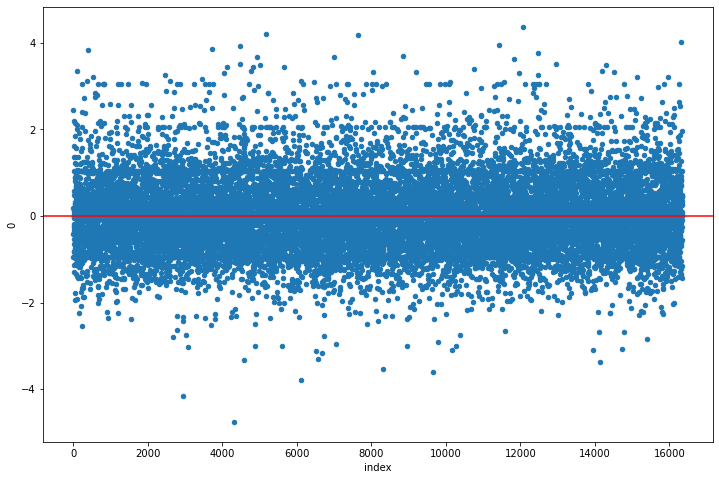

In [52]:
errors = pd.Series(predictions) - pd.Series(y_test)
#Comparing estimate to true values
plt.figure()
ax = pd.DataFrame(errors).reset_index().plot(kind="scatter", x="index", y=0, figsize=(12, 8))
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [53]:
print("Baseline Model (3) MSE: ", str((errors**2).mean()))

Baseline Model (3) MSE:  0.7180235336473143


**Temporal Dynamics Feature**<br />
(David)<br />


In [ ]:
interactions=[]
interactionsPerUser=defaultdict(list)
userIDs={}
itemIDs={}
for i in range(len(X_train)):
    d=X_train[i]
    user = d[6]
    if user == None: continue
    business = d[3]
    if business == None: continue
    time = d[4]
    if time == None: continue
    rating = y_train[i]
    if not user in userIDs: userIDs[user] = len(userIDs)
    if not business in itemIDs: itemIDs[business] = len(itemIDs)
    interactionsPerUser[user].append([time,business,rating])
    interactions.append((time,user,business,rating))

In [ ]:
interactionsPerItem = defaultdict(list)
for t,u,i,r in interactions:
    interactionsPerItem[i].append((t,u,r))

In [ ]:
def featTemporal(t,u,i):
    if t == None: return [1,0,1,0,1,0,1,0,1,0,1,0]
    older = [r for (q,u,r) in interactionsPerItem[i] if q < t] # Collect previous ratings
    f = []
    for k in range(1,6):
        try:
            f += [0,older[-k]] # Previous rating
        except Exception as e:
            f += [1,0] # Or missing value indicator if we don't have history of length k
    if len(older):
        f += [0,sum(older)/len(older)] # Add feature for the average (going beyond just last k)
    else:
        f += [1,0] # Missing value indicator if no interaction history
    return f

**Price?**<br />
(Andrew)<br />
One-Hot Encoding

In [55]:
#Setup price for each businessID
priceKey = defaultdict(str)
for d in places_CA:
    if d['price'] == None:
        priceKey[d["gPlusPlaceId"]] = ""
    else:
        priceKey[d["gPlusPlaceId"]] = d['price']

In [56]:
uniquePrice = ['','$','$$','$$$']
catID = dict(zip(uniquePrice,range(len(uniquePrice))))
print(catID)

{'': 0, '$': 1, '$$': 2, '$$$': 3}


In [57]:
def featPrice(d):
    businessID = d[3]
    price = priceKey[businessID]
    feat = [0]*len(catID)
    if price in catID:
        feat[catID[price]] = 1
    
    return feat

**Sentiment Analysis**<br />
(Maricela)

In [59]:
stop_words = set(stopwords.words('english'))

In [60]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in X_train:
    if type(d[1]) == str:
        r = ''.join([c for c in d[1].lower() if not c in punctuation])
        for w in r.split():
            if w not in stop_words:
                wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [61]:
counts[:10]

[(20147, 'good'),
 (20095, 'food'),
 (19505, 'great'),
 (16132, 'place'),
 (9726, 'service'),
 (8014, 'like'),
 (7999, 'get'),
 (7375, 'best'),
 (7167, 'one'),
 (7087, 'really')]

In [62]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [63]:
def featureSentiment(d):
    feat = [0]*len(words)
    if type(d[1]) == str:
        r = ''.join([c for c in d[1].lower() if not c in punctuation])
        ws = r.split()
        ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
        ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
        ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
        ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
        for w in ws + ws2 + ws3 + ws4 + ws5:
            if w in words:
                feat[wordId[w]] += 1
    return feat

# Item2Vec

In [64]:
from gensim.models import Word2Vec

In [65]:
reviewsPerUser = defaultdict(list)
for d in X_train:
    if d[4] and d[3]:
        reviewsPerUser[d[6]].append((d[4], d[3]))

In [66]:
reviewLists = []
for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    reviewLists.append([x[1] for x in rl])

In [67]:
model10 = Word2Vec(reviewLists,
                 min_count=5, # Words/items with fewer instances are discarded
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [68]:
itemAverages = defaultdict(list)
reviewsPerUser = defaultdict(list)
    
for i in range(len(X_train)):
    d = X_train[i]
    f = d[3]
    u = d[6]
    if d[3]:
        itemAverages[f].append(y_train[i])
    reviewsPerUser[u].append(d+[y_train[i]])
    
for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])

In [69]:
def predictRatingI2V(user,item):
    ratings = []
    similarities = []
    if not str(item) in model10.wv:
        return ratingsGlobalAvg
    for d in reviewsPerUser[user]:
        i2 = d[3]
        if i2 == item: continue
        ratings.append(d[7] - itemAverages[i2])
        if str(i2) in model10.wv:
            similarities.append(model10.wv.distance(str(item), str(i2)))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        return ratingsGlobalAvg

# **Final Model**

In [70]:
from sklearn.metrics import mean_squared_error
from sklearn import linear_model

In [102]:
def feature(d,A=True,B=True,C=True,D=True,E=True):
    feat = [1]
    #sentiment feature
    if A:
        feat = feat + featureSentiment(d)
        
    #cosine feature
    if B:
        feat = feat + [predictRatingCos(d[6],d[3])]
        
    #price OHE
    if C:
        feat = feat + featPrice(d)
    
    #Item2Vec
    if D:
        feat = feat + [predictRatingI2V(d[6],d[3])]
    
    #simple temporal
    if E:
        feat = feat + featTemporal(d[4],d[6],d[3])
    
    return feat

In [103]:
Xtrain = [feature(d) for d in X_train]
ytrain = y_train
Xval = [feature(d) for d in X_val]
yval = y_val
Xtest = [feature(d) for d in X_test]
ytest = y_test

In [105]:
clf = linear_model.Ridge(1, fit_intercept=False) # MSE + 1.0 l2
clf.fit(np.array(Xtrain), np.array(ytrain))
theta = clf.coef_
predsVal = clf.predict(np.array(Xval))
predsTrain = clf.predict(np.array(Xtrain))
MSEtrain = mean_squared_error(ytrain,predsTrain)
MSEval = mean_squared_error(yval,predsVal)
predsTest = clf.predict(np.array(Xtest))
MSEtest = mean_squared_error(predsTest,ytest)
print(MSEtrain,MSEval,MSEtest)

0.4544782820298481 0.6067924572659833 0.6051944755996631


In [106]:
def ablation(AA=True,BB=True,CC=True,DD=True,EE=True):
    Xtrain = [feature(d,A=AA,B=BB,C=CC,D=DD,E=EE) for d in X_train]
    ytrain = y_train
    Xval = [feature(d,A=AA,B=BB,C=CC,D=DD,E=EE) for d in X_val]
    yval = y_val
    #Xtest = [feature(d,A=AA,B=BB,C=CC,D=DD,E=EE) for d in X_test]
    #ytest = y_test
    
    clf = linear_model.Ridge(1, fit_intercept=False) # MSE + 1.0 l2
    clf.fit(np.array(Xtrain), np.array(ytrain))
    
    predsTrain = clf.predict(np.array(Xtrain))
    MSEtrain = mean_squared_error(ytrain,predsTrain)
    
    predsVal = clf.predict(np.array(Xval))
    MSEval = mean_squared_error(yval,predsVal)
    return [MSEtrain,MSEval]

In [112]:
ablation()

[0.4544782820298481, 0.6067924572659833]

In [107]:
#user sentiment
ablation(AA=False)

[0.5131987584734263, 0.690998299531068]

In [108]:
#cosine similarity
ablation(BB=False)

[0.50938937438104, 0.5731831085386149]

In [109]:
#price OHE
ablation(CC=False)

[0.4552269876349528, 0.6081454764609387]

In [110]:
#Item2Vec
ablation(DD=False)

[0.4545724412972433, 0.6116569367981328]

In [111]:
#simple temporal
ablation(EE=False)

[0.4574044817694373, 0.5991903145102386]